In [21]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import scipy.signal
import rasterio
import rasterio.features
from rasterio import MemoryFile
from affine import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from scipy.ndimage import gaussian_filter
import shapely
from shapely.geometry import Polygon, shape, MultiPolygon
import subprocess as sp

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

## Read rasters and clean data

In [32]:
S3R = S3Helper('roof-index')

slope = S3R.read_tif_from_s3_as_rio("missoula/geospatial/downtown_slope.tif" ) 

# Read buildings and select only flat buildings
bldgs_path = "missoula/geospatial/downtown_flat_beta.zip"
bldgs = S3R.read_shp_from_s3_as_gpd(bldgs_path).to_crs(6514)

# Only select flat rooftops
bldgs = bldgs[bldgs['flat'] == 1]
bldgs

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,fa_sq_ft,fa_perc,flat,geometry
5,6.0,16.38070,3207.39,30646.000,5500.116176,17.947256,1,"POLYGON ((257451.605 300206.114, 257451.537 30..."
16,17.0,9.06969,3204.35,197.999,19.202401,9.698231,1,"POLYGON ((257088.830 300230.819, 257093.734 30..."
35,36.0,37.84540,3201.73,4450.480,765.352825,17.197085,1,"POLYGON ((257140.164 300339.379, 257141.784 30..."
63,64.0,20.97450,3207.92,1864.120,422.452814,22.662319,1,"POLYGON ((257327.874 300138.016, 257325.736 30..."
64,65.0,23.17660,3204.36,1957.490,375.818412,19.198995,1,"POLYGON ((257300.417 300176.916, 257307.502 30..."
...,...,...,...,...,...,...,...,...
931,932.0,12.69410,3213.11,5707.100,1357.884043,23.792890,1,"POLYGON ((258042.400 301302.344, 258047.027 30..."
932,933.0,12.49470,3213.15,1270.120,172.821606,13.606715,1,"POLYGON ((258073.881 301282.201, 258069.436 30..."
943,944.0,11.74680,3213.46,431.998,41.148001,9.525044,1,"POLYGON ((258048.690 301463.792, 258051.335 30..."
944,945.0,7.86698,3213.09,179.999,16.459201,9.144051,1,"POLYGON ((258036.225 301369.632, 258035.091 30..."


## Polygonize the raster using  GDAL

In [37]:
def polygonize(arr, meta):
    
    """
    arr: np.array to be converted to polygons
    meta: metadata to georeference new polygons.
    """
    
    # Make temporary directory to perform polygonize operations in.
    temp = 'temp'
    if not os.path.isdir(temp):
        print('Making temporary directory.')
        os.mkdir(temp)

    # Write raster to temp directory
    f = os.path.join(temp, 'flat_tmp.tif')
    out = rasterio.open(f, 'w', **meta)
    out.write(arr[np.newaxis].astype(np.float32))
    out.close()

    # Polygonize and return shapefile
    sp.call(['gdal_polygonize.py', f, os.path.join(temp, 'polys.shp')])
    flat_vec = gpd.read_file(os.path.join(temp, 'polys.shp'))
    flat_vec = flat_vec[flat_vec['DN'] != 0]
    
    # Remove temporary directory
    shutil.rmtree(temp)

    return flat_vec


# Taken from https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
# Converts all multipolygons to individual polygons in a gdf.
def explode(indf):
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

def polygonize_filter(slope_raster, bldgs):
    
    """
    slope_raster: rio object of slope.
    bldgs: gdf of building footprints.
    """
    
    # If the building slope is less than 45 degrees, classify as flat.
    flat = np.where(slope_raster.read(1) <= 45, 1, 0)
    
    # Convert flat np.array to polygon.
    flat_vector = polygonize(flat, slope_raster.meta)
    
    # Spatial join of buildings and flat areas.
    joined = gpd.overlay(flat_vector, bldgs, how='intersection')
    
    # Drop unnecessary column. 
    joined = joined.drop(columns='DN')
    
    # Convert all the multipolygons to individual polygons.
    joined = explode(joined)
        
    # Calculate area and remove polygons smaller than 1000 sq. ft. 
    # Filter buildings with an area smaller than 1000 Sq. Ft.
    joined['area'] = joined['geometry'].area * 10.7639
    joined = joined[joined['area'] > 1000]
    
    return joined

## Calculate Useable Area

Making temporary directory.


<AxesSubplot:>

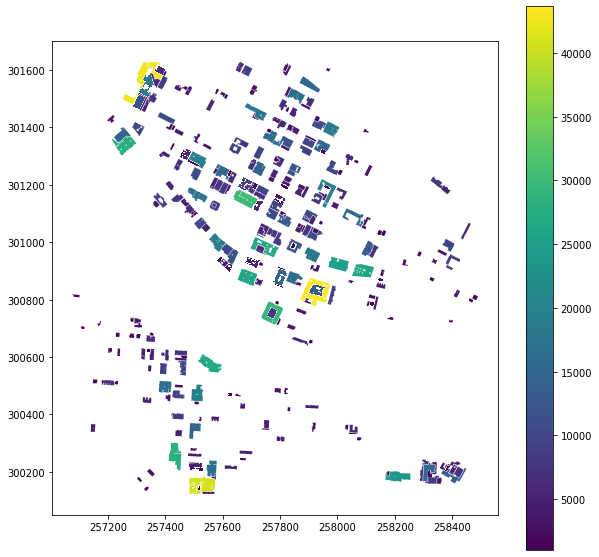

In [38]:
flat_areas = polygonize_filter(slope, bldgs)

fig, ax = plt.subplots(1,1, figsize=(10,10))
flat_areas.plot(column='area', ax=ax, legend=True)

In [28]:
flat_areas

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,fa_sq_ft,fa_perc,flat,geometry,area
0,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257829.710 301620.326, 257829.710 30...",8581.47
1,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257833.368 301597.466, 257833.368 30...",8581.47
2,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257809.594 301589.237, 257809.594 30...",8581.47
3,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257832.499 301618.498, 257833.368 30...",8581.47
4,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257812.337 301586.494, 257812.337 30...",8581.47
...,...,...,...,...,...,...,...,...,...
1456,64.0,20.97450,3207.92,1864.12,422.452814,22.662319,1,"POLYGON ((257338.678 300149.057, 257338.678 30...",1864.12
1457,97.0,9.50192,3208.20,2110.49,301.752010,14.297723,1,"POLYGON ((257510.585 300279.816, 257510.585 30...",2110.49
1460,660.0,11.37430,3194.67,1406.24,312.724810,22.238367,1,"POLYGON ((258041.851 300868.690, 258042.720 30...",1406.24
1463,825.0,9.79395,3212.68,1193.62,260.604008,21.833080,1,"POLYGON ((257973.271 301601.124, 257973.271 30...",1193.62


In [36]:
flat_areas_exploded['area'] = flat_areas_exploded['geometry'].area
flat_areas_exploded

,DN,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,fa_sq_ft,fa_perc,flat,geometry,area
0,1,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257829.710 301620.326, 257829.710 30...",3.454789
1,1,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257833.368 301597.466, 257833.368 30...",1.207153
2,1,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257809.594 301589.237, 257809.594 30...",6.562543
3,1,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257832.499 301618.498, 257833.368 30...",352.207404
4,1,870.0,25.46260,3209.65,8581.47,1009.497632,11.763691,1,"POLYGON ((257812.337 301586.494, 257812.337 30...",1.672255
...,...,...,...,...,...,...,...,...,...,...
1589,1,660.0,11.37430,3194.67,1406.24,312.724810,22.238367,1,"POLYGON ((258041.851 300868.690, 258042.720 30...",115.760582
1590,1,825.0,9.79395,3212.68,1193.62,260.604008,21.833080,1,"POLYGON ((257973.271 301601.124, 257973.271 30...",98.053403
1591,1,874.0,24.89470,3208.06,6717.35,721.461623,10.740271,1,"POLYGON ((257654.146 301616.669, 257654.146 30...",530.244230
1592,1,874.0,24.89470,3208.06,6717.35,721.461623,10.740271,1,"POLYGON ((257652.317 301615.954, 257651.994 30...",1.031243
